In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define your root path
root_path = r"new_collect"

data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Reshape data to combine the first three dimensions; each row corresponds to one observation across the 10 channels
X_reshaped = X.reshape(-1, X.shape[-1])
print(f"Reshaped data for PCA: {X_reshaped.shape}")

# Run PCA to examine channel contributions
pca = PCA(n_components=10)
pca.fit(X_reshaped)



Loading processed data...
Data shape: (1724, 19, 100, 10), Labels shape: (1724,)
Reshaped data for PCA: (3275600, 10)


PCA(n_components=10)

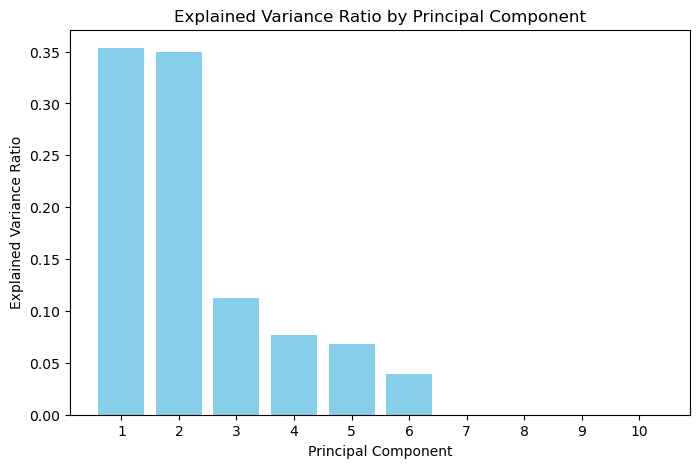

In [2]:
# Plot explained variance ratio per component
plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(components)
plt.show()



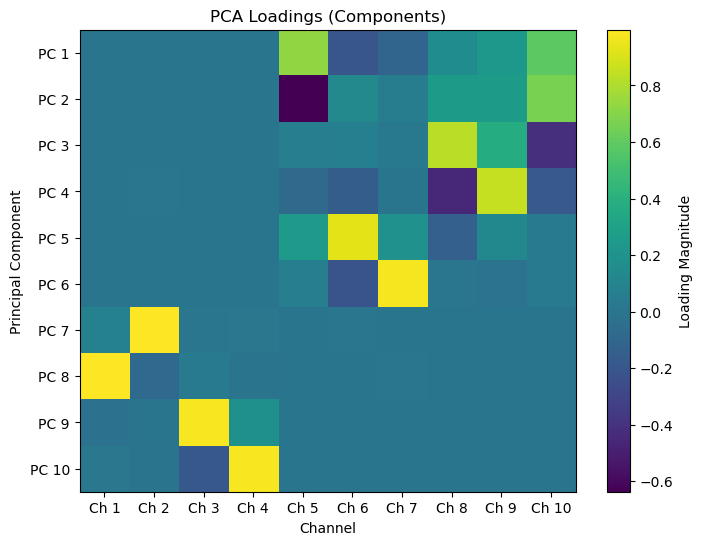

In [3]:
# Visualize the PCA loadings as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar(label='Loading Magnitude')
plt.xlabel('Channel')
plt.ylabel('Principal Component')
plt.title('PCA Loadings (Components)')
plt.xticks(np.arange(10), [f"Ch {i+1}" for i in range(10)])
plt.yticks(np.arange(10), [f"PC {i+1}" for i in range(10)])
plt.show()

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """Loads gesture dataset and splits into train/test sets."""
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path, allow_pickle=True)
    y = np.load(label_path, allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

def extract_emg_features(signal, fs=1000):
    """Extracts features from an EMG signal (100 time steps)."""
    mav = np.mean(np.abs(signal))  # Mean Absolute Value
    rms = np.sqrt(np.mean(signal**2))  # Root Mean Square
    var = np.var(signal)  # Variance
    zc = np.sum(np.diff(np.sign(signal)) != 0)  # Zero Crossing Count
    wl = np.sum(np.abs(np.diff(signal)))  # Waveform Length

    # Frequency-domain features using FFT
    fft_vals = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    power = np.abs(fft_vals)**2
    total_power = np.sum(power)
    mean_freq = np.sum(freqs * power) / total_power if total_power else 0

    cumsum_power = np.cumsum(power)
    median_freq = freqs[np.where(cumsum_power >= total_power/2)[0][0]] if total_power else 0

    return np.array([mav, rms, var, zc, wl, mean_freq, median_freq])

def synthesize_time_series(features, num_timesteps=100):
    """
    Generates a synthetic time series of length `num_timesteps` from extracted features.
    Uses Gaussian noise centered at the mean feature values.
    """
    synthesized_signal = np.zeros((num_timesteps,))
    
    for i, feature in enumerate(features):
        synthesized_signal += feature * np.sin(2 * np.pi * (i + 1) * np.linspace(0, 1, num_timesteps))
    
    return synthesized_signal + np.random.normal(0, 0.05, num_timesteps)  # Add small noise

def replace_emg_with_synthetic_data(X, fs=1000):
    """
    Replaces the first 4 EMG channels in each window with synthesized time series
    generated from extracted features, while keeping the last 6 IMU channels unchanged.

    Parameters:
    - X: Shape (num_samples, num_windows, num_timesteps, num_channels)
    - fs: Sampling frequency

    Returns:
    - X_new: Same shape as X, but with EMG channels replaced by synthetic features
    """
    num_samples, num_windows, num_timesteps, num_channels = X.shape
    new_X = np.copy(X)  # Keep the original structure

    for i in range(num_samples):
        for j in range(num_windows):
            for ch in range(4):  # Replace only the first 4 EMG channels
                features = extract_emg_features(X[i, j, :, ch], fs)
                new_X[i, j, :, ch] = synthesize_time_series(features, num_timesteps)

    return new_X

# Load original data
data_folder = r"new_collect"  
X_train, X_test, y_train, y_test = load_data(data_folder)

# Replace EMG channels with synthesized time series
X_train_new = replace_emg_with_synthetic_data(X_train, fs=1000)
X_test_new = replace_emg_with_synthetic_data(X_test, fs=1000)

print(f"New training data shape: {X_train_new.shape}")
print(f"New testing data shape: {X_test_new.shape}")


Loading processed data...
Data shape: (1724, 19, 100, 10), Labels shape: (1724,)
Training set: (1379, 19, 100, 10), Testing set: (345, 19, 100, 10)
New training data shape: (1379, 19, 100, 10)
New testing data shape: (345, 19, 100, 10)


In [6]:
# Merge train and test sets for PCA analysis
X_merged = np.concatenate([X_train_new, X_test_new], axis=0)
print(f"Merged feature data shape: {X_merged.shape}")
# Reshape data to combine the first three dimensions; each row corresponds to one observation across the 10 channels
X_reshaped = X_merged.reshape(-1, X_merged.shape[-1])
print(f"Reshaped data for PCA: {X_reshaped.shape}")

# Run PCA to examine feature contributions
pca = PCA(n_components=min(10, X_reshaped.shape[1]))  # Ensure n_components doesn't exceed feature count
pca.fit(X_reshaped)


Merged feature data shape: (1724, 19, 100, 10)
Reshaped data for PCA: (3275600, 10)


PCA(n_components=10)

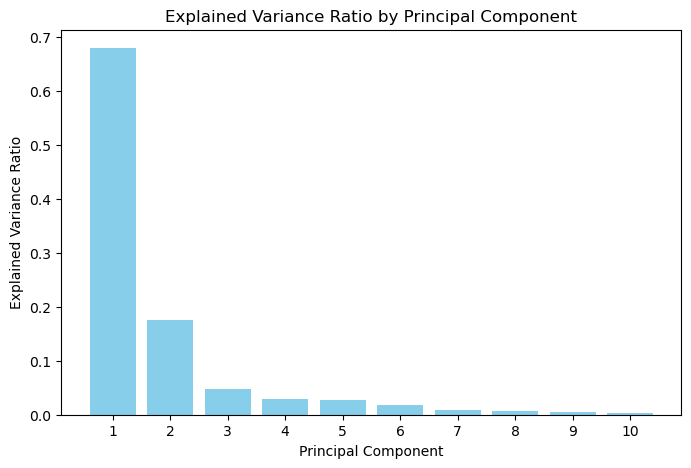

In [7]:
# Plot explained variance ratio per component
plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(components)
plt.show()



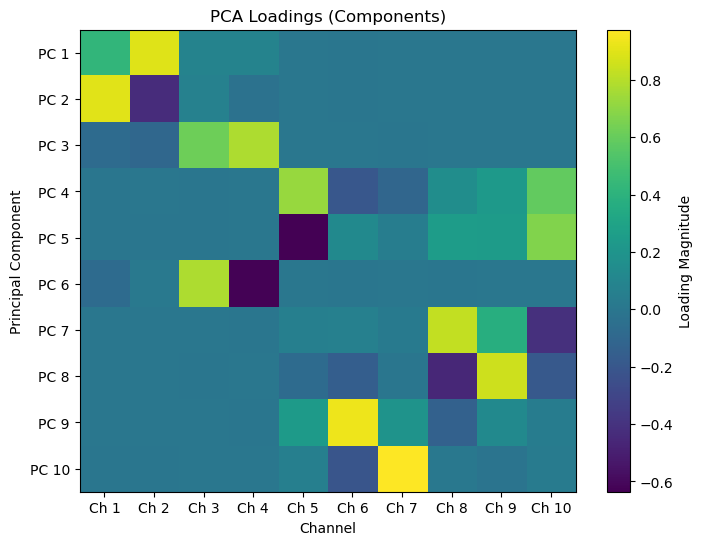

In [8]:
# Visualize the PCA loadings as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar(label='Loading Magnitude')
plt.xlabel('Channel')
plt.ylabel('Principal Component')
plt.title('PCA Loadings (Components)')
plt.xticks(np.arange(10), [f"Ch {i+1}" for i in range(10)])
plt.yticks(np.arange(10), [f"PC {i+1}" for i in range(10)])
plt.show()

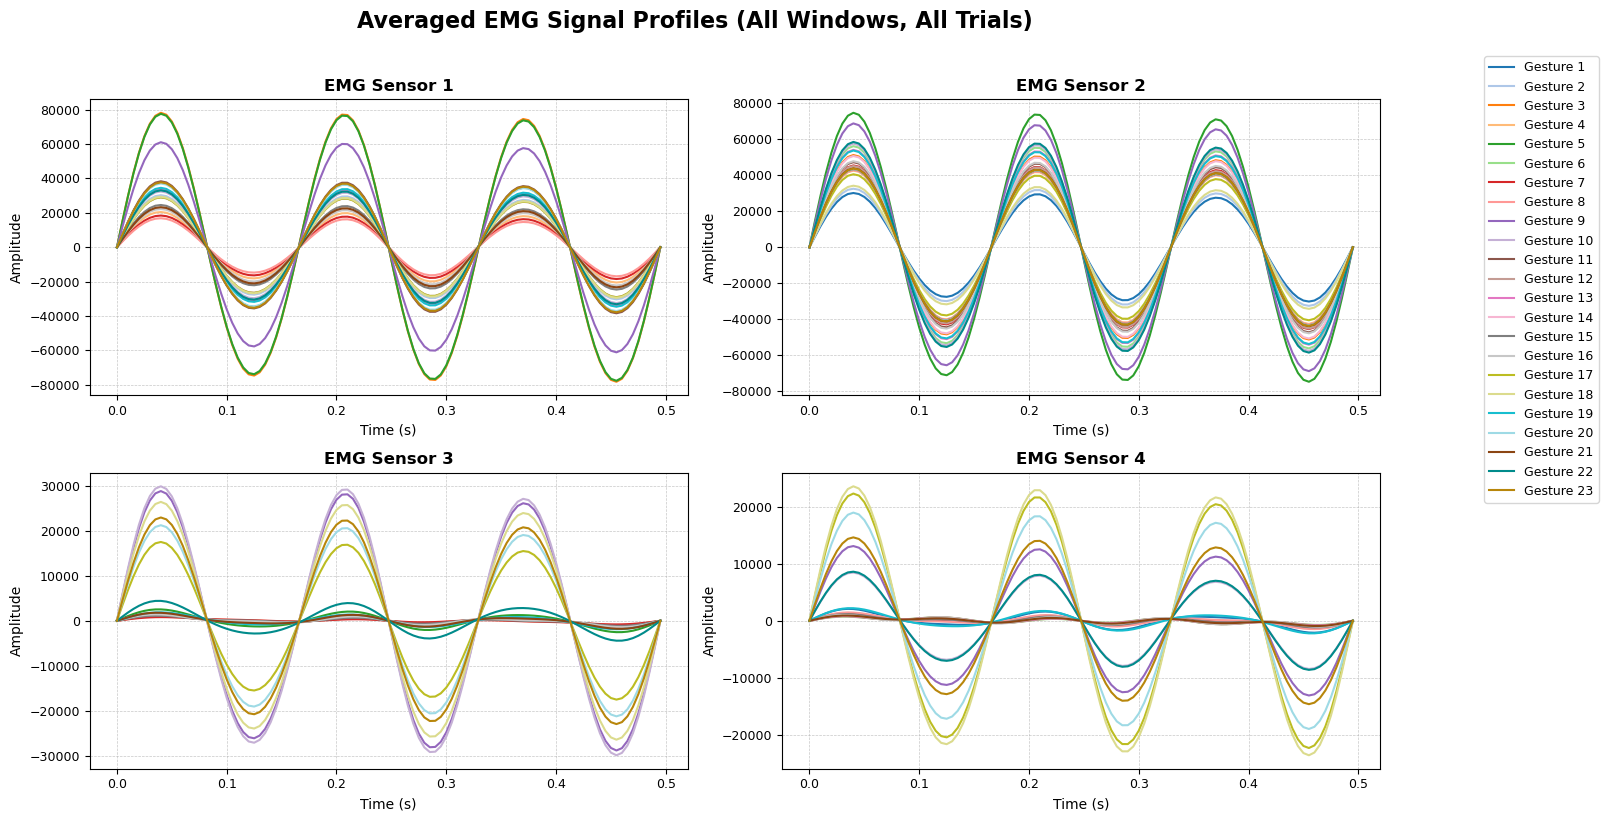

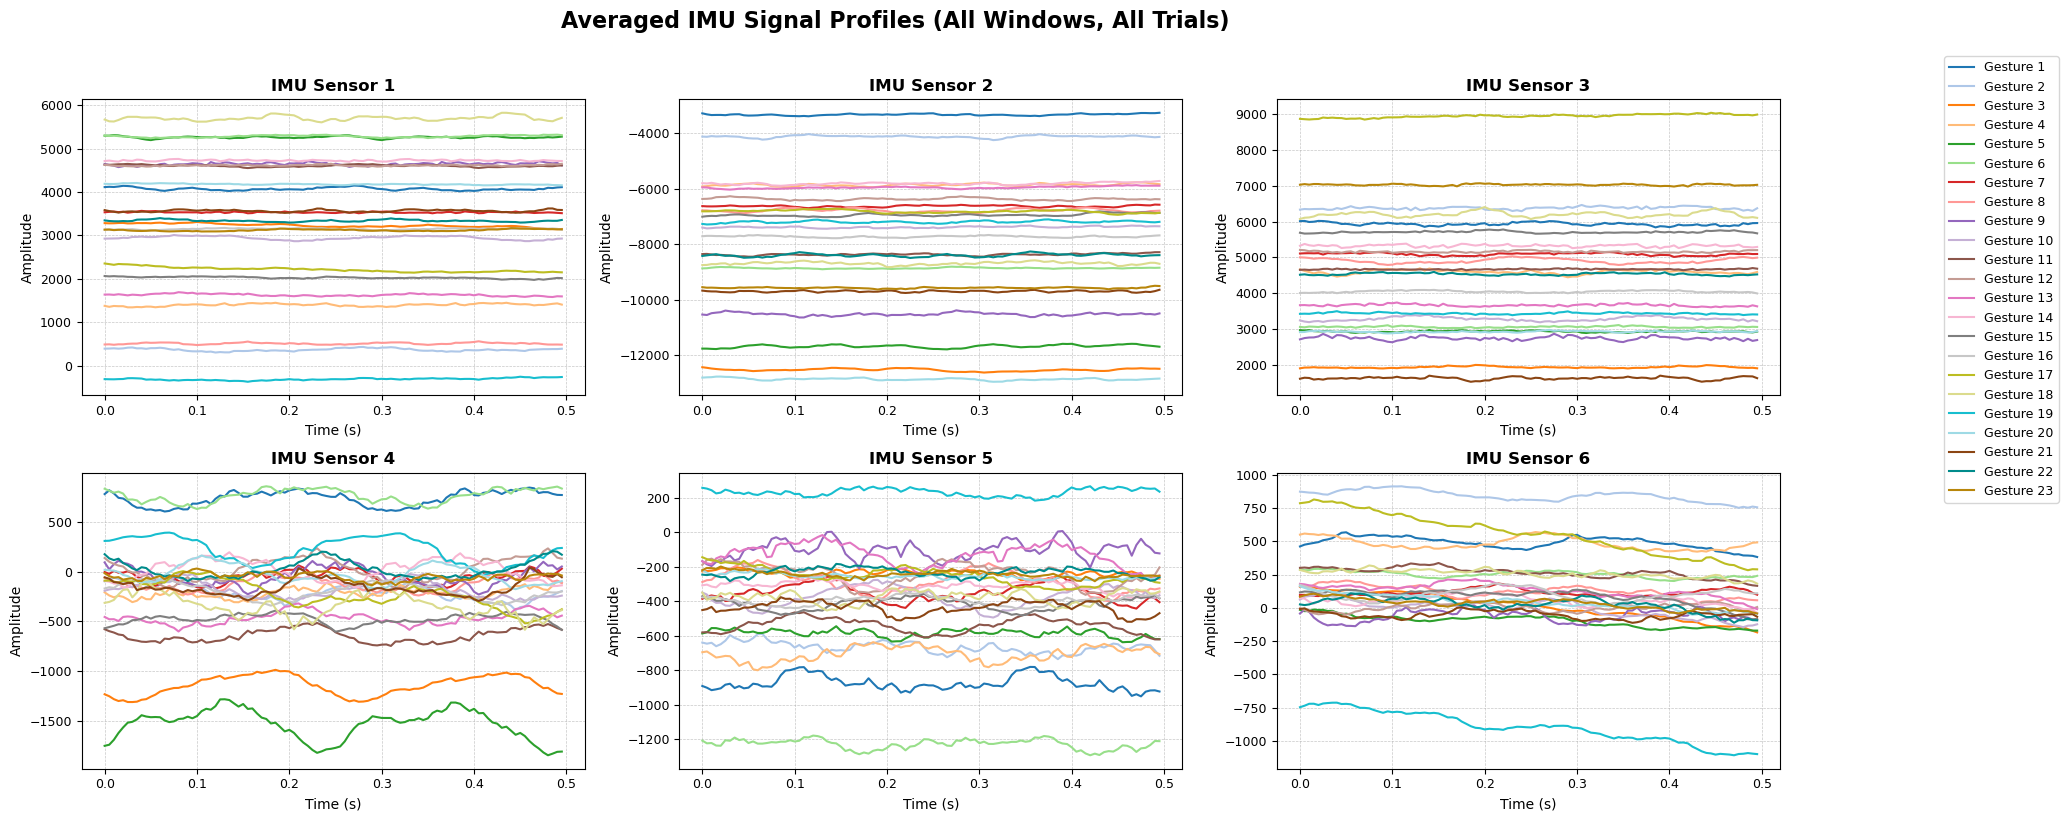

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

##############################################################################
# USER-DEFINED PARAMETERS
##############################################################################
sampling_rate = 200  # Hz, adjust based on your setup if known (e.g., 200 Hz)
emg_channels = [0, 1, 2, 3]  # Indices of EMG sensors
imu_channels = [4, 5, 6, 7, 8, 9]  # Indices of IMU sensors

##############################################################################
# LOAD PROCESSED DATA
##############################################################################
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. "
#                             "Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)  # Shape: (n_trials, n_windows, window_length, n_channels)
# y = np.load(label_path, allow_pickle=True)

# # Basic checks
# if X.ndim != 4:
#     raise ValueError("Expected 4D array with shape (n_trials, n_windows, window_length, n_channels).")
# print("Data shape:", X.shape)  # For debugging

X = X_merged
y = np.concatenate([y_train, y_test], axis=0)

##############################################################################
# COMPUTE AVERAGE & STD PROFILES
##############################################################################
unique_gestures = np.sort(np.unique(y))
n_gestures = len(unique_gestures)

avg_profiles = {}
std_profiles = {}

for gesture in unique_gestures:
    # Find indices of all trials for this gesture
    gesture_indices = np.where(y == gesture)[0]
    # Concatenate windows from all trials along axis=0
    # Shape => (n_trials * n_windows, window_length, n_channels)
    gesture_data = np.concatenate([X[idx] for idx in gesture_indices], axis=0)
    # Compute mean & std across the first axis (all windows)
    avg_profiles[gesture] = np.mean(gesture_data, axis=0)  # (window_length, n_channels)
    std_profiles[gesture] = np.std(gesture_data, axis=0)   # (window_length, n_channels)

##############################################################################
# PREPARE TIME AXIS
##############################################################################
# We'll convert sample indices to time in seconds: t = indices / sampling_rate
window_length = next(iter(avg_profiles.values())).shape[0]
time_axis = np.arange(window_length) / sampling_rate  # shape: (window_length,)

##############################################################################
# DEFINE A COLOR PALETTE
##############################################################################
# Use tab20 for up to 20 gestures, then add extras if needed.
base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
# Add extra distinct colors if you have more than 20 gestures
extra_colors = [
    "#8B4513", "#008B8B", "#B8860B", "#556B2F",
    "#CD5C5C", "#4B0082", "#006400", "#8B008B"
]
colors = list(base_colors) + extra_colors
colors = colors[:n_gestures]  # Ensure we have at least one color per gesture

##############################################################################
# PLOT AVERAGED EMG PROFILES (2x2 layout)
##############################################################################
fig_emg, axes_emg = plt.subplots(2, 2, figsize=(14, 8), sharex=False, sharey=False)
axes_emg = axes_emg.flatten()  # Flatten to easily iterate

fig_emg.suptitle("Averaged EMG Signal Profiles (All Windows, All Trials)", 
                 fontsize=16, fontweight='bold', y=1.02)

for i, ch in enumerate(emg_channels):
    ax = axes_emg[i]
    for gesture_idx, gesture in enumerate(unique_gestures):
        avg_signal = avg_profiles[gesture][:, ch]
        std_signal = std_profiles[gesture][:, ch]
        ax.plot(time_axis, avg_signal, color=colors[gesture_idx],
                linewidth=1.5, label=f"Gesture {gesture}")
        # ax.fill_between(time_axis,
        #                 avg_signal - std_signal,
        #                 avg_signal + std_signal,
        #                 color=colors[gesture_idx], alpha=0.2)
    ax.set_title(f"EMG Sensor {ch+1}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("Amplitude", fontsize=10)
    ax.tick_params(axis='both', labelsize=9)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Create a single legend outside the plots
handles, labels = axes_emg[0].get_legend_handles_labels()
fig_emg.legend(handles, labels, loc="upper right", fontsize=9, frameon=True, 
               bbox_to_anchor=(1.15, 0.97))
plt.tight_layout()
plt.show()

##############################################################################
# PLOT AVERAGED IMU PROFILES (2x3 layout)
##############################################################################
fig_imu, axes_imu = plt.subplots(2, 3, figsize=(18, 8), sharex=False, sharey=False)
axes_imu = axes_imu.flatten()

fig_imu.suptitle("Averaged IMU Signal Profiles (All Windows, All Trials)", 
                 fontsize=16, fontweight='bold', y=1.02)

for i, ch in enumerate(imu_channels):
    ax = axes_imu[i]
    for gesture_idx, gesture in enumerate(unique_gestures):
        avg_signal = avg_profiles[gesture][:, ch]
        std_signal = std_profiles[gesture][:, ch]
        ax.plot(time_axis, avg_signal, color=colors[gesture_idx],
                linewidth=1.5, label=f"Gesture {gesture}")
        # ax.fill_between(time_axis,
        #                 avg_signal - std_signal,
        #                 avg_signal + std_signal,
        #                 color=colors[gesture_idx], alpha=0.2)
    # Renumber IMU sensors for clarity (1-based indexing for display)
    ax.set_title(f"IMU Sensor {ch - imu_channels[0] + 1}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("Amplitude", fontsize=10)
    ax.tick_params(axis='both', labelsize=9)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Create a single legend outside the plots
handles, labels = axes_imu[0].get_legend_handles_labels()
fig_imu.legend(handles, labels, loc="upper right", fontsize=9, frameon=True,
               bbox_to_anchor=(1.15, 0.97))
plt.tight_layout()
plt.show()


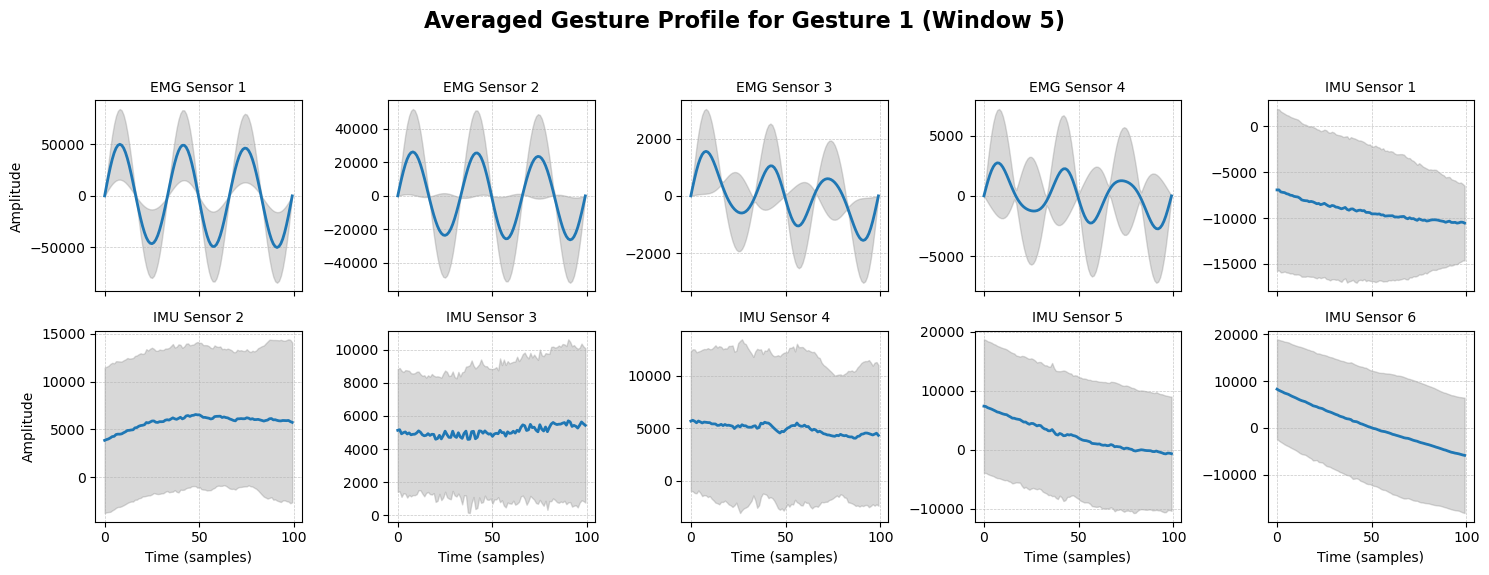

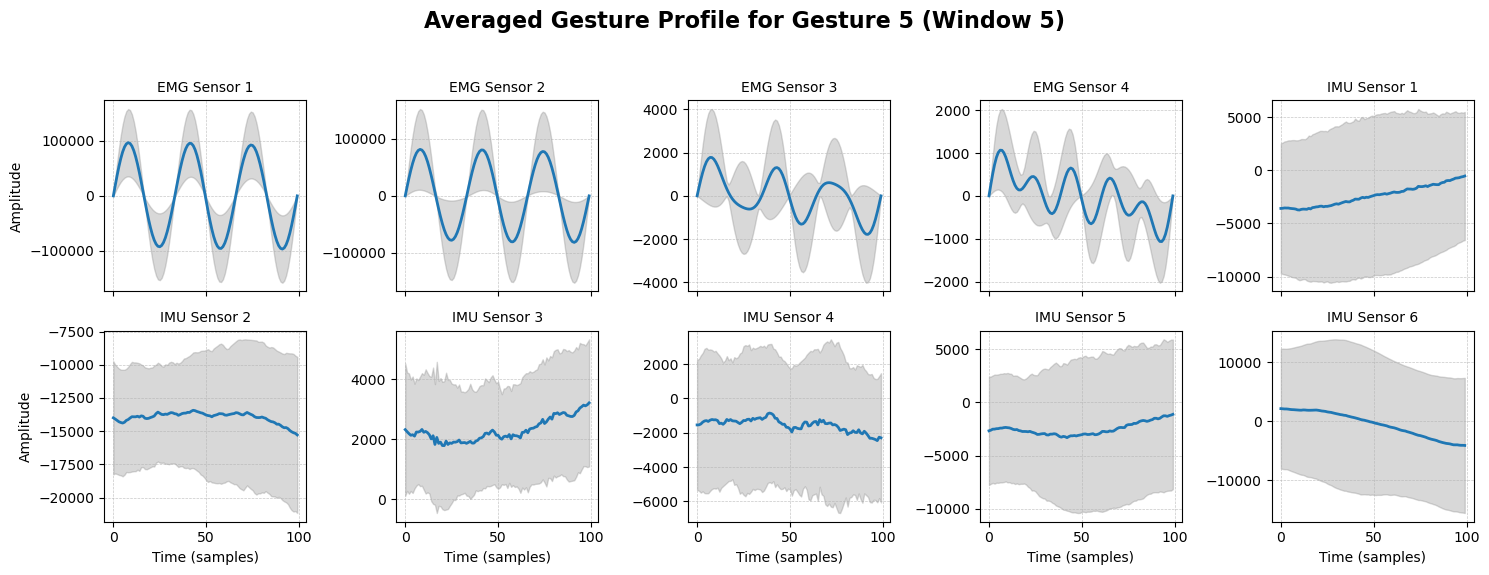

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the root path where processed data is stored

# # Load processed data and labels
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)
# y = np.load(label_path, allow_pickle=True)

# Define a helper function to extract a representative trial signal.
# If the processed data is 4D (n_trials, n_windows, window_length, n_channels),
# we select the first window as the representative window.
if X.ndim == 4:
    get_representative_trial = lambda idx: X[idx, 5, :, :]
elif X.ndim == 3:
    get_representative_trial = lambda idx: X[idx, :, :]
else:
    raise ValueError("Unexpected dimensions in processed gesture data")

# For each gesture, compute and plot the averaged gesture profile
unique_gestures = np.unique(y)

for gesture in [1, 5]: # unique_gestures
    indices = np.where(y == gesture)[0]
    if len(indices) == 0:
        continue

    # Extract a representative window from each trial for the current gesture
    trials = [get_representative_trial(idx) for idx in indices]
    trials = np.array(trials)  # Shape: (num_trials, window_length, n_channels)

    # Compute average and standard deviation across trials (axis=0)
    avg_signal = np.mean(trials, axis=0)
    std_signal = np.std(trials, axis=0)

    window_length = trials.shape[1]
    time_axis = np.arange(window_length)
    n_channels = trials.shape[2]

    # Create subplots for each sensor channel.
    # Assuming 10 channels (4 EMG and 6 IMU), we use 2 rows x 5 columns.
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6), sharex=True)
    fig.suptitle(f"Averaged Gesture Profile for Gesture {gesture} (Window 5)", fontsize=16, fontweight='bold')

    for ch in range(n_channels):
        ax = axes[ch // ncols, ch % ncols]
        # Plot the average signal with a thick line
        ax.plot(time_axis, avg_signal[:, ch], linewidth=2, label="Average")
        # Fill the area between average ± standard deviation
        ax.fill_between(time_axis,
                        avg_signal[:, ch] - std_signal[:, ch],
                        avg_signal[:, ch] + std_signal[:, ch],
                        color='gray', alpha=0.3, label="Std Dev")
        # Label sensor type: channels 0-3 are EMG, channels 4-9 are IMU
        if ch < 4:
            sensor_type = "EMG"
            sensor_id = ch + 1
        else:
            sensor_type = "IMU"
            sensor_id = ch - 3  # For example, channel 4 becomes IMU 1
        ax.set_title(f"{sensor_type} Sensor {sensor_id}", fontsize=10)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        if ch % ncols == 0:
            ax.set_ylabel("Amplitude", fontsize=10)
    # Set x-label on the bottom row subplots only
    for ax in axes[-1]:
        ax.set_xlabel("Time (samples)", fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


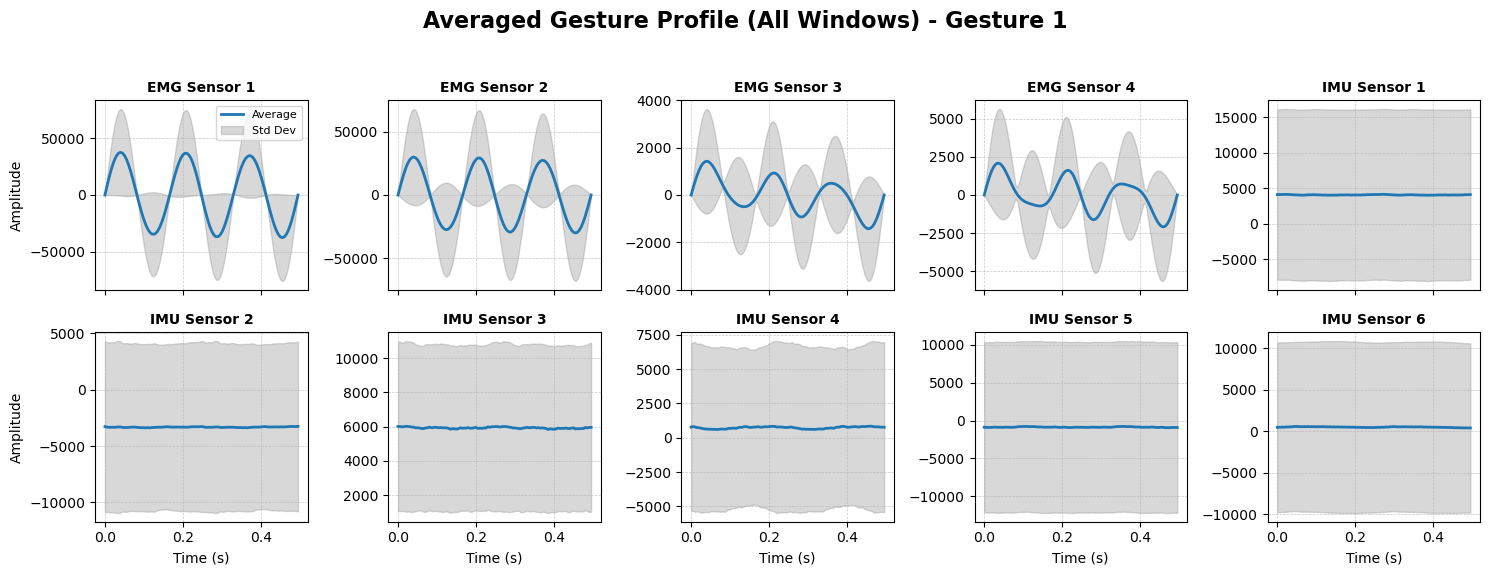

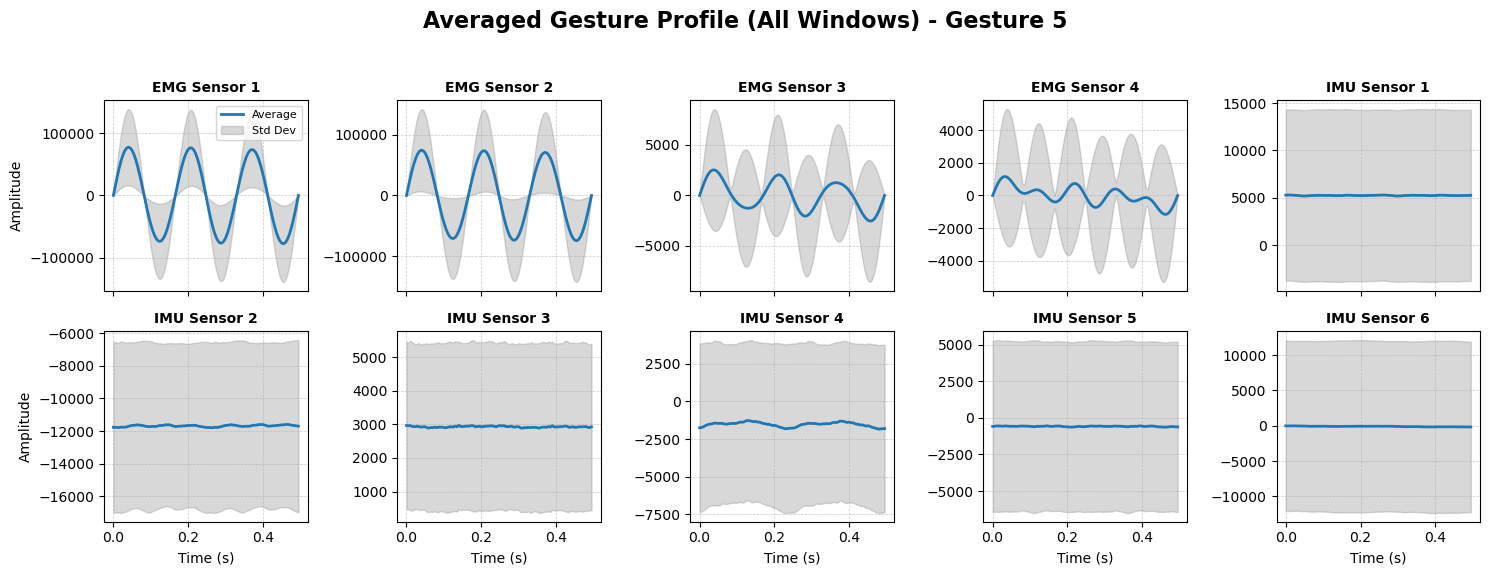

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

##############################################################################
# USER-DEFINED: ROOT PATH, SAMPLING RATE, & GESTURES TO PLOT
##############################################################################
sampling_rate = 200             # Hz (e.g., 200 Hz); adjust as needed
gestures_to_plot = [1, 5]       # Change this list to whichever gestures you want

##############################################################################
# LOAD PROCESSED DATA
##############################################################################
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. "
#                             "Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)
# y = np.load(label_path, allow_pickle=True)

# # Check that data is 4D: (n_trials, n_windows, window_length, n_channels)
# if X.ndim != 4:
#     raise ValueError("Expected 4D array of shape (n_trials, n_windows, window_length, n_channels).")

# print("Data shape:", X.shape)  # For debugging

##############################################################################
# FOR EACH GESTURE, AVERAGE OVER ALL WINDOWS ACROSS ALL TRIALS
##############################################################################
# unique_gestures = np.unique(y)  # If you want to plot all gestures, uncomment

for gesture in gestures_to_plot:
    # Find all trials corresponding to this gesture
    indices = np.where(y == gesture)[0]
    if len(indices) == 0:
        print(f"No trials found for Gesture {gesture}. Skipping.")
        continue

    # Concatenate all windows from these trials along axis=0
    # Shape => (n_trials * n_windows, window_length, n_channels)
    gesture_data = np.concatenate([X[idx] for idx in indices], axis=0)

    # Compute average and standard deviation across axis=0 (all windows)
    avg_signal = np.mean(gesture_data, axis=0)  # (window_length, n_channels)
    std_signal = np.std(gesture_data, axis=0)   # (window_length, n_channels)

    window_length = avg_signal.shape[0]
    n_channels = avg_signal.shape[1]

    # Convert sample indices to time in seconds
    time_axis = np.arange(window_length) / sampling_rate

    # Create a 2×5 grid of subplots for the 10 channels (4 EMG + 6 IMU).
    # Adjust if you have a different number of channels.
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6), sharex=True, sharey=False)
    axes = axes.flatten()

    fig.suptitle(f"Averaged Gesture Profile (All Windows) - Gesture {gesture}",
                 fontsize=16, fontweight='bold')

    for ch in range(n_channels):
        ax = axes[ch]
        # Plot the average signal
        ax.plot(time_axis, avg_signal[:, ch], linewidth=2, label="Average")
        # Fill the area between (avg - std) and (avg + std)
        ax.fill_between(time_axis,
                        avg_signal[:, ch] - std_signal[:, ch],
                        avg_signal[:, ch] + std_signal[:, ch],
                        color='gray', alpha=0.3, label="Std Dev")

        # Label the sensor: channels 0–3 are EMG, channels 4–9 are IMU
        if ch < 4:
            sensor_type = "EMG"
            sensor_id = ch + 1
        else:
            sensor_type = "IMU"
            sensor_id = ch - 3  # e.g., channel 4 => IMU Sensor 1

        ax.set_title(f"{sensor_type} Sensor {sensor_id}", fontsize=10, fontweight='bold')
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        if ch // ncols == nrows - 1:  # bottom row
            ax.set_xlabel("Time (s)", fontsize=10)
        if ch % ncols == 0:          # first column
            ax.set_ylabel("Amplitude", fontsize=10)

    # Only one legend is needed; place it on the first subplot or anywhere you prefer
    axes[0].legend(fontsize=8, loc='upper right', frameon=True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
